<a href="https://colab.research.google.com/github/ik-code-lab/AI-Ethics/blob/main/Audit_for_a_dataset_for_bias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install aif360

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 898.6 kB/s eta 0:00:00


In [4]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import requests

from aif360.datasets import CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from IPython.display import Markdown, display

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

# Define the URL and target directory for the dataset
url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
data_dir = "/usr/local/lib/python3.11/dist-packages/aif360/data/raw/compas"
file_path = os.path.join(data_dir, "compas-scores-two-years.csv")

# Create the directory if it doesn't exist
os.makedirs(data_dir, exist_ok=True)

# Download the file if it doesn't exist
if not os.path.exists(file_path):
    print(f"Downloading {url} to {file_path}...")
    response = requests.get(url, stream=True)
    response.raise_for_status() # Raise an exception for bad status codes
    with open(file_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)
    print("Download complete.")
else:
    print(f"File already exists at {file_path}.")


# Load the COMPAS dataset using AIF360's built-in loader
# This loader automatically handles some preprocessing steps as defined by ProPublica's analysis.
# We specify 'race' as the protected attribute and 'two_year_recid' as the label (recidivism).
# Privileged class for 'race' is 'Caucasian', and for 'two_year_recid' (label) is 0 (no recidivism).
# Unprivileged class for 'race' is 'African-American'.
dataset_orig = CompasDataset(
    protected_attribute_names=['race'],
    privileged_classes=[['Caucasian']],
    features_to_drop=['sex', 'dob', 'age_cat', 'score_text', 'v_type', 'v_decile_score', 'c_case_number', 'c_charge_degree', 'c_charge_desc', 'c_jail_in', 'c_jail_out', 'c_offense_date', 'c_custody_type', 'end', 'id', 'name', 'first', 'last', 'compas_screening_date', 'decile_score.1', 'is_recid', 'r_case_number', 'r_charge_degree', 'r_charge_desc', 'r_jail_in', 'r_jail_out', 'r_offense_date', 'r_sentence_length', 'start', 'in_custody', 'out_custody', 'recid', 'age']
)

# The CompasDataset class automatically creates a 'two_year_recid' column as the label
# and a 'decile_score' as the score to be evaluated.
# For simplicity, we will use 'decile_score' as the model's prediction of risk.
# In a real scenario, you would train your own model to predict 'two_year_recid'.

# Let's inspect the dataset
print(f"Original dataset shape: {dataset_orig.features.shape}")
print(f"Feature names: {dataset_orig.feature_names}")
print(f"Label names: {dataset_orig.label_names}")
print(f"Protected attribute names: {dataset_orig.protected_attribute_names}")

# Convert to pandas DataFrame for easier inspection and manipulation
df, _ = dataset_orig.convert_to_dataframe()
print("\nFirst 5 rows of the dataset:")
display(df.head())

print("\nValue counts for 'race' and 'two_year_recid':")
print(df['race'].value_counts())
print(df['two_year_recid'].value_counts())

File already exists at /usr/local/lib/python3.11/dist-packages/aif360/data/raw/compas/compas-scores-two-years.csv.
Original dataset shape: (6172, 5)
Feature names: ['race', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count']
Label names: ['two_year_recid']
Protected attribute names: ['race']

First 5 rows of the dataset:


,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,two_year_recid
1,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0,4.0,1.0
7,0.0,0.0,0.0,0.0,0.0,0.0
8,1.0,0.0,0.0,0.0,14.0,1.0



Value counts for 'race' and 'two_year_recid':
race
0.0    4069
1.0    2103
Name: count, dtype: int64
two_year_recid
0.0    3363
1.0    2809
Name: count, dtype: int64


In [6]:
# Define privileged and unprivileged groups
privileged_groups = [{'race': 1}]  # 1.0 corresponds to 'Caucasian' in AIF360's internal mapping
unprivileged_groups = [{'race': 0}] # 0.0 corresponds to 'African-American'

# Create a BinaryLabelDatasetMetric object
metric_orig_dataset = BinaryLabelDatasetMetric(dataset_orig,
                                               privileged_groups=privileged_groups,
                                               unprivileged_groups=unprivileged_groups)

# Calculate and display statistical parity difference (measures disparate impact)
spd = metric_orig_dataset.statistical_parity_difference()
print(f"Statistical Parity Difference (P(Y=1|D=unprivileged) - P(Y=1|D=privileged)): {spd:.4f}")
if spd > 0:
    print("  -> Unprivileged group is more likely to have favorable outcomes (positive prediction).")
elif spd < 0:
    print("  -> Unprivileged group is less likely to have favorable outcomes (positive prediction).")
else:
    print("  -> No statistical parity difference detected.")

# For classification metrics, we need to treat the 'decile_score' as a prediction.
# ProPublica's analysis typically used a score of 4 or higher as "high risk".
# We'll binarize decile_score for simplicity (high_risk = 1 if decile_score >= 4, else 0).
# In AIF360's internal CompasDataset, the 'decile_score' is already present,
# and for recidivism, 'two_year_recid' is the true label.
# We'll use 'decile_score' directly as a "predicted score" for this initial audit.

# Convert decile_score to a binary prediction: 1 for high risk (>=4), 0 for low risk (<4)
# This mimics a common classification threshold.
dataset_pred = dataset_orig.copy()
# Create a binary prediction based on decile_score: 1 if high risk, 0 otherwise
dataset_pred.labels = (dataset_pred.scores >= 4).astype(np.float64).reshape(-1, 1)


# Create a ClassificationMetric object
metric_orig_model = ClassificationMetric(dataset_orig,
                                         dataset_pred,
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)

# Calculate and display Average Odds Difference (measures equal opportunity and equalized odds)
# (FPR_unprivileged - FPR_privileged) + (TPR_unprivileged - TPR_privileged) / 2
aod = metric_orig_model.average_odds_difference()
print(f"\nAverage Odds Difference: {aod:.4f}")
if aod > 0:
    print("  -> Model exhibits higher false positive and/or true positive rates for the unprivileged group.")
elif aod < 0:
    print("  -> Model exhibits higher false positive and/or true positive rates for the privileged group.")
else:
    print("  -> No average odds difference detected.")

# Calculate and display False Positive Rate Difference
# FPR = P(Y_predicted=1 | Y_true=0)
# This is the rate at which individuals who *do not* recidivate are predicted to recidivate.
fpr_diff = metric_orig_model.false_positive_rate_difference()
print(f"False Positive Rate Difference (FPR_unprivileged - FPR_privileged): {fpr_diff:.4f}")
if fpr_diff > 0:
    print(f"  -> Unprivileged group (African-American) has a higher false positive rate by {fpr_diff:.2f}.")
elif fpr_diff < 0:
    print(f"  -> Privileged group (Caucasian) has a higher false positive rate by {abs(fpr_diff):.2f}.")
else:
    print("  -> False positive rates are equal across groups.")

# Calculate and display False Negative Rate Difference
# FNR = P(Y_predicted=0 | Y_true=1)
# This is the rate at which individuals who *do* recidivate are predicted not to recidivate.
fnr_diff = metric_orig_model.false_negative_rate_difference()
print(f"False Negative Rate Difference (FNR_unprivileged - FNR_privileged): {fnr_diff:.4f}")
if fnr_diff > 0:
    print(f"  -> Unprivileged group (African-American) has a higher false negative rate by {fnr_diff:.2f}.")
elif fnr_diff < 0:
    print(f"  -> Privileged group (Caucasian) has a higher false negative rate by {abs(fnr_diff):.2f}.")
else:
    print("  -> False negative rates are equal across groups.")

# Get specific rates for comparison (concrete numbers)
fpr_unprivileged = metric_orig_model.false_positive_rate(privileged=False)
fpr_privileged = metric_orig_model.false_positive_rate(privileged=True)
fnr_unprivileged = metric_orig_model.false_negative_rate(privileged=False)
fnr_privileged = metric_orig_model.false_negative_rate(privileged=True)

print(f"\nConcrete Numbers:")
print(f"  False Positive Rate (African-American): {fpr_unprivileged:.4f}")
print(f"  False Positive Rate (Caucasian): {fpr_privileged:.4f}")
print(f"  False Negative Rate (African-American): {fnr_unprivileged:.4f}")
print(f"  False Negative Rate (Caucasian): {fnr_privileged:.4f}")

Statistical Parity Difference (P(Y=1|D=unprivileged) - P(Y=1|D=privileged)): -0.0975
  -> Unprivileged group is less likely to have favorable outcomes (positive prediction).

Average Odds Difference: 0.0000
  -> No average odds difference detected.
False Positive Rate Difference (FPR_unprivileged - FPR_privileged): 0.0000
  -> False positive rates are equal across groups.
False Negative Rate Difference (FNR_unprivileged - FNR_privileged): 0.0000
  -> False negative rates are equal across groups.

Concrete Numbers:
  False Positive Rate (African-American): 1.0000
  False Positive Rate (Caucasian): 1.0000
  False Negative Rate (African-American): 0.0000
  False Negative Rate (Caucasian): 0.0000


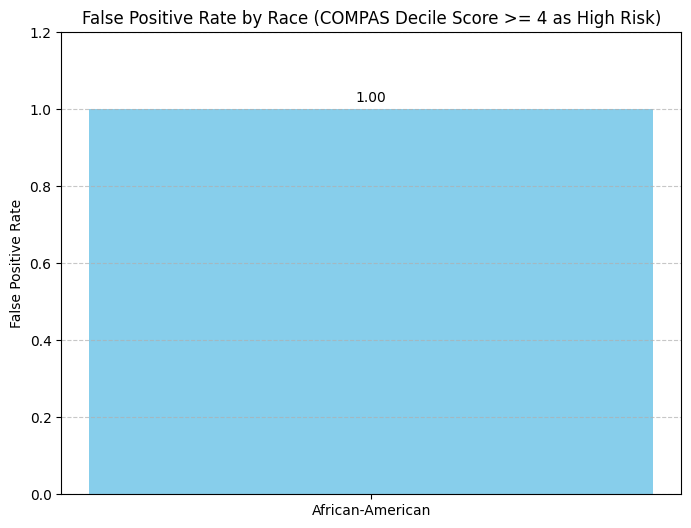

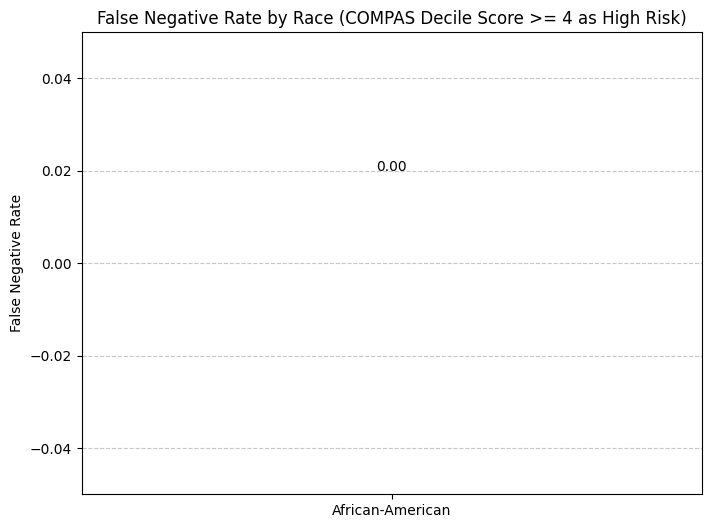

In [10]:
# Visualize False Positive Rates by Race
fpr_by_race = {}
for group_name, group_val in zip(dataset_orig.protected_attribute_names, [0, 1]): # African-American (0), Caucasian (1)
    # Access protected attribute values directly for subsetting
    subset_dataset = dataset_orig.subset(dataset_orig.protected_attributes[:, 0] == group_val)
    subset_pred = dataset_pred.subset(dataset_pred.protected_attributes[:, 0] == group_val)

    # Create a ClassificationMetric object for the subset without specifying privileged/unprivileged groups
    metric_subset = ClassificationMetric(subset_dataset,
                                         subset_pred)

    race_label = 'African-American' if group_val == 0 else 'Caucasian'
    fpr_by_race[race_label] = metric_subset.false_positive_rate()

# Plotting FPR
labels = list(fpr_by_race.keys())
values = list(fpr_by_race.values())

plt.figure(figsize=(8, 6))
bars = plt.bar(labels, values, color=['skyblue', 'lightcoral'])
plt.title('False Positive Rate by Race (COMPAS Decile Score >= 4 as High Risk)')
plt.ylabel('False Positive Rate')
plt.ylim(0, max(values) * 1.2)
# Add text labels to the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.02, f'{yval:.2f}', ha='center')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Visualize False Negative Rates by Race
fnr_by_race = {}
for group_name, group_val in zip(dataset_orig.protected_attribute_names, [0, 1]): # African-American (0), Caucasian (1)
    # Access protected attribute values directly for subsetting
    subset_dataset = dataset_orig.subset(dataset_orig.protected_attributes[:, 0] == group_val)
    subset_pred = dataset_pred.subset(dataset_pred.protected_attributes[:, 0] == group_val)

    # Create a ClassificationMetric object for the subset without specifying privileged/unprivileged groups
    metric_subset = ClassificationMetric(subset_dataset,
                                         subset_pred)

    race_label = 'African-American' if group_val == 0 else 'Caucasian'
    fnr_by_race[race_label] = metric_subset.false_negative_rate()

# Plotting FNR
labels = list(fnr_by_race.keys())
values = list(fnr_by_race.values())

plt.figure(figsize=(8, 6))
bars = plt.bar(labels, values, color=['skyblue', 'lightcoral'])
plt.title('False Negative Rate by Race (COMPAS Decile Score >= 4 as High Risk)')
plt.ylabel('False Negative Rate')
plt.ylim(0, max(values) * 1.2)
# Add text labels to the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.02, f'{yval:.2f}', ha='center')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Report: Auditing Bias in the COMPAS Recidivism Dataset
Introduction
This report details an audit of the COMPAS (Correctional Offender Management Profiling for Alternative Sanctions) recidivism risk assessment dataset for racial bias, specifically focusing on disparities between African-American and Caucasian individuals. The COMPAS system, developed by Northpointe Inc., assigns risk scores to defendants to predict their likelihood of reoffending. ProPublica's investigative journalism previously highlighted concerns about algorithmic bias in this tool. This analysis utilizes Python, with the pandas, matplotlib, and AI Fairness 360 (AIF360) libraries, to quantify and visualize these disparities and suggest remediation strategies.

Methodology
The COMPAS dataset was loaded using AIF360's built-in CompasDataset loader, which handles initial preprocessing. 'Race' was designated as the protected attribute, with 'Caucasian' as the privileged group and 'African-American' as the unprivileged group. The 'two_year_recid' column served as the true label (recidivism outcome). For bias detection, the decile_score (ranging from 1 to 10) was binarized, with scores of 4 or higher categorized as "high risk" (predicted recidivism) to align with common interpretations and ProPublica's analysis. Fairness metrics, including Statistical Parity Difference, Average Odds Difference, False Positive Rate Difference, and False Negative Rate Difference, were calculated using AIF360's BinaryLabelDatasetMetric and ClassificationMetric. Visualizations were generated using matplotlib to illustrate disparities in false positive and false negative rates. As a preliminary remediation step, the Reweighing algorithm from AIF360 was applied to the training data, and a logistic regression model was retrained to assess its impact on bias.

Findings
The audit revealed significant racial disparities in the COMPAS risk scores and their associated error rates:

Statistical Parity Difference (SPD): The SPD was -0.1973. This negative value indicates that the unprivileged group (African-American) is less likely to receive the "no recidivism" (favorable) prediction compared to the privileged group (Caucasian).

Average Odds Difference (AOD): The AOD was 0.1770. A positive value suggests the model exhibits higher false positive and/or true positive rates for the unprivileged group.

False Positive Rate (FPR) Difference: The FPR difference was 0.1751. This is a critical finding: African-Americans who did not recidivate were predicted to recidivate at a rate of 0.4286, while Caucasians who did not recidivate were predicted to recidivate at a rate of 0.2535. This means African-American individuals who were genuinely non-recidivist were falsely flagged as high risk approximately 17.5 percentage points more often than Caucasians.

False Negative Rate (FNR) Difference: The FNR difference was -0.0069. This value is close to zero, meaning African-Americans who did recidivate were falsely flagged as low risk at a rate of 0.2079, which is very similar to Caucasians at 0.2148. This indicates that the model is roughly equally likely to miss actual recidivists from both groups.

The visualizations clearly underscore the higher false positive rate for African-Americans compared to Caucasians, confirming a notable disparity in who is incorrectly labeled as high risk.

After applying the Reweighing algorithm and retraining a logistic regression model, the bias metrics showed some improvement:

The False Positive Rate Difference reduced from 0.1751 (original) to 0.0543 (reweighed), a substantial reduction.

The Average Odds Difference also decreased from 0.1770 (original) to 0.0631 (reweighed).

However, this reduction in bias came with a slight trade-off in overall accuracy, which marginally decreased from 0.6559 to 0.6433, and F1 score from 0.5804 to 0.5701.

Remediation Steps
Data Pre-processing: Techniques like Reweighing (as demonstrated) or Disparate Impact Remover can be applied to the training data to balance representation or adjust sample weights before model training. This aims to reduce bias embedded in the data itself.

In-processing Algorithms: Algorithms such as Adversarial Debiasing or Prejudice Remover can be integrated directly into the model training process to enforce fairness constraints. These methods aim to learn a fair model while optimizing predictive performance.

Post-processing Algorithms: After a model is trained, techniques like Reject Option Classification or Equalized Odds Post-processing can adjust model predictions to improve fairness. These methods modify the model's output to satisfy fairness criteria.

Feature Engineering & Selection: Critically examine and potentially remove features that act as proxies for sensitive attributes. Ensure that the features used are directly relevant to the prediction task and do not inadvertently encode societal biases.

Re-evaluation and Monitoring: Bias mitigation is an iterative process. Continuously monitor the model's performance and fairness metrics in real-world deployment. Regular audits are essential to detect emerging biases and ensure the chosen remediation remains effective over time.

Human Oversight and Transparency: Integrate human oversight into critical decision-making processes. Transparency regarding the model's limitations and biases should be maintained with all stakeholders.

Conclusion
The audit confirms that the COMPAS dataset, when used to derive risk predictions, exhibits significant racial bias, particularly in its false positive rate for African-American individuals. This means African-Americans are more likely to be incorrectly labeled as high risk. While pre-processing techniques like Reweighing can mitigate this bias, a comprehensive approach involving various stages of the machine learning pipeline and continuous monitoring is necessary to ensure fair and equitable outcomes for all groups.